In [41]:
import torch
import torch.nn as nn 
from torchvision import  datasets, models, transforms 
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
import os 
from collections import Counter
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report



In [26]:
transform = transforms.Compose([
    
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #* these  values i use for grayscale since the chest x rays is 
])

In [27]:
data_dir = './Datasets/LungXRays-grayscale'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
print(f'training data: {len(train_dataset)}')
print(f'validation data: {len(val_dataset)}')
print(f'test data: {len(test_dataset)}')

 


training data: 4861
validation data: 1620
test data: 1625


In [ ]:
#TODO  check for the distribuation classes
def get_class_distribution(dataset): 
    counter_pr_class = Counter([dataset.classes[label] for _, label in dataset.imgs])
    return counter_pr_class



def get_class_distribution(dataset): 
    counter_pr_class = Counter([dataset.classes[label] for _, label in dataset.imgs])
    return counter_pr_class   
train_distribution = get_class_distribution(train_dataset)
print(train_distribution)


Counter({'COVID19': 1218, 'Pneumonia': 1218, 'Tuberculosis': 1218, 'Normal': 1207})


In [29]:
##* datasets loader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True); 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
imgs, labels = next(dataiter)
print(imgs.shape)
print(torch.min(imgs), torch.max(imgs))
print(f'images shapes: {imgs.shape}')

torch.Size([32, 3, 128, 128])
tensor(-1.) tensor(1.)
images shapes: torch.Size([32, 3, 128, 128])


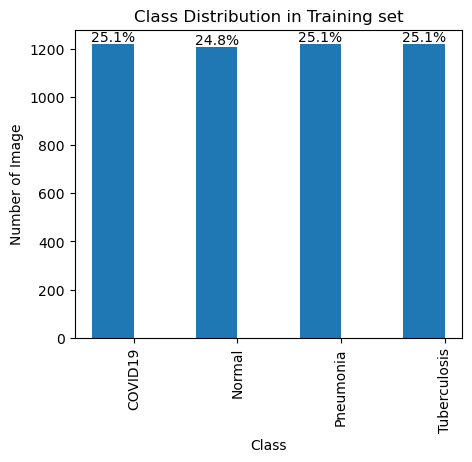

In [30]:
def plot_combined_distributions(original_dist,  dataset_name='Training Set'): 
    
    classes = list(original_dist.keys())
    original_counts = [original_dist[cls] for cls in classes]
    total_count = sum(original_counts)
 
    
    x = range(len(classes))
    width = 0.4 
    
    plt.figure(figsize=(5, 4))
    bars = plt.bar(x, original_counts, width=width, label = 'Original', align='center')
    #plt.bar([p + width for p in x], sample_counts, width=width, label ='weighted sampled', align='center')
    
    
    for bar, count in zip(bars, original_counts): 
        percent = (count / total_count) * 100
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height(), 
            f'{percent:.1f}%', 
            ha= 'center', 
            va=  'bottom'
        )
        

    plt.xlabel('Class')
    plt.ylabel('Number of Image')
    plt.title('Class Distribution in Training set')

    plt.xticks([p+width / 2 for p in x], classes, rotation = 90)
   
    plt.show()

plot_combined_distributions(train_distribution )




In [31]:
#pred trained model DenseNet121 
num_classes = len(train_dataset.classes)
densenet_model = models.densenet121()
#making modification of the number of class
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, num_classes)


In [32]:
#Hyperparamaters 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = densenet_model.to(device) 
criterion = nn.CrossEntropyLoss();  
optimizer = optim.Adam(model.parameters(), lr=0.0001, )
#optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
num_epoch = 10

In [33]:
#* we need to train the module 

def train_model(model, train_loader, criterion, optimizer, device):
    
    
    
        #* we sting the model into train mode
    model.train(); 
    
    learning_loss = 0.0; 
    correct = 0; 
    total = 0; 
    
    for inputs, labels in train_loader: 
        
        inputs, labels = inputs.to(device), labels.to(device)
        #* starting with the gradient from  the intial point 0 
        optimizer.zero_grad()
        outputs = model(inputs); 
        loss = criterion(outputs, labels); 
        loss.backward();
        optimizer.step(); 
        learning_loss += loss.item(); 
        _, predict = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item(); 
    
    learning_loss_result = learning_loss / total if total > 0 else 0
    train_acc = 100 * correct /total if total > 0 else 0
    return learning_loss_result, train_acc
                

In [34]:
### evaluation the model

def validation(model, val_loader, criterion, device ): 
    model.eval(); 
    running_loss = 0.0; 
    total = 0; 
    correct = 0; 
    
    with torch.no_grad(): 
        for inputs, labels in val_loader: 
            inputs, labels = inputs.to(device), labels.to(device); 
            outputs = model(inputs); 
            loss = criterion(outputs, labels); 
            running_loss += loss.item(); 
            _,predict = torch.max(outputs, 1); 
            
            total  += labels.size(0); 
            correct  += (predict == labels).sum().item()
            
    result_running_loss = running_loss / total if total > 0 else 0 
    result_val_acc = 100* correct / total if total > 0 else 0; 
    return  result_running_loss, result_val_acc; 

In [35]:
train_losses, train_accs, val_losses, val_accs =[], [], [], []
for epoch in range(num_epoch):
    
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validation(model, val_loader, criterion, device)
    train_losses.append(train_loss); 
    train_accs.append(train_acc); 
    val_losses.append(val_loss)
    val_accs.append(val_acc); 

    print(f'Epoch {epoch+1}/{num_epoch}: Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    

Epoch 1/10: Train Loss: 0.0185 Train Acc: 78.0086, Val Loss: 0.0117, Val Acc: 86.2963
Epoch 2/10: Train Loss: 0.0110 Train Acc: 87.4511, Val Loss: 0.0094, Val Acc: 88.8272
Epoch 3/10: Train Loss: 0.0093 Train Acc: 88.9940, Val Loss: 0.0083, Val Acc: 90.5556
Epoch 4/10: Train Loss: 0.0079 Train Acc: 91.1335, Val Loss: 0.0068, Val Acc: 91.7901
Epoch 5/10: Train Loss: 0.0072 Train Acc: 92.0592, Val Loss: 0.0072, Val Acc: 92.5309
Epoch 6/10: Train Loss: 0.0063 Train Acc: 92.4090, Val Loss: 0.0056, Val Acc: 93.9506
Epoch 7/10: Train Loss: 0.0057 Train Acc: 93.3347, Val Loss: 0.0063, Val Acc: 92.9630
Epoch 8/10: Train Loss: 0.0052 Train Acc: 94.0547, Val Loss: 0.0060, Val Acc: 92.9630
Epoch 9/10: Train Loss: 0.0047 Train Acc: 94.6307, Val Loss: 0.0062, Val Acc: 93.2099
Epoch 10/10: Train Loss: 0.0045 Train Acc: 94.7130, Val Loss: 0.0066, Val Acc: 92.5926


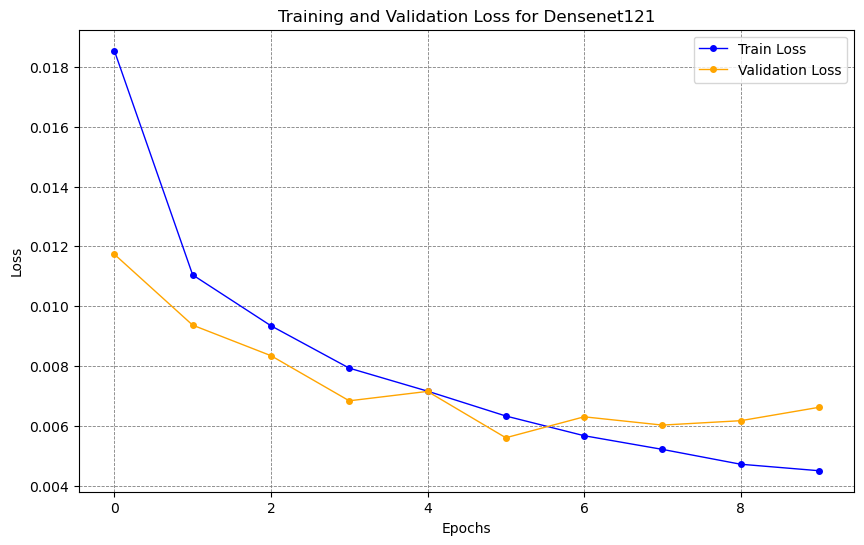

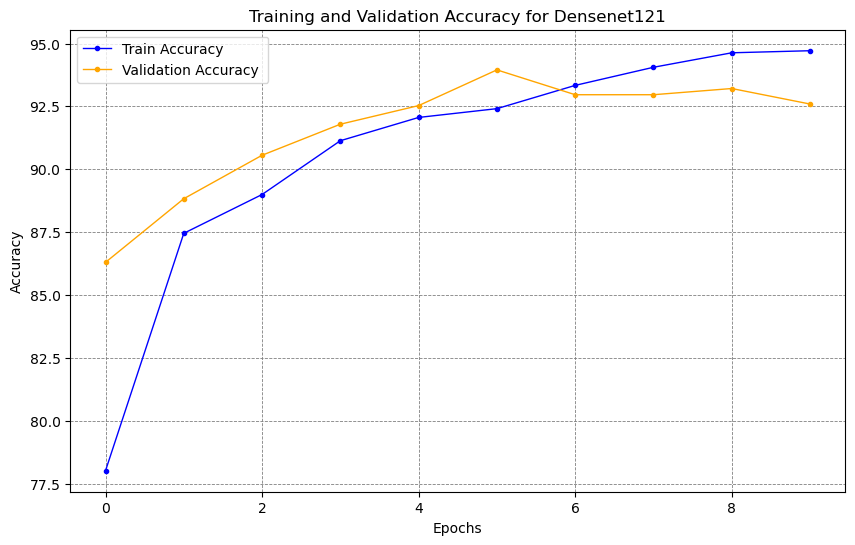

In [38]:
def Plot_metrics(train_losses, val_losses, train_accs, val_accs):
    #* range for the plot 
    epoch = list(range(0, num_epoch))
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_losses, label= 'Train Loss', color = 'blue',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.plot(epoch, val_losses, label='Validation Loss', color='orange',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Densenet121')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()
    
    
    epoch = list(range(0, num_epoch))
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_accs, label= 'Train Accuracy ', color = 'blue',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.plot(epoch, val_accs, label='Validation Accuracy ', color='orange',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy for Densenet121')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()



Plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [39]:
# evaluation 

#*  Model evaluation 
def evaluation (model, test_loader,  criterion, device ):
    test_loss = 0.0;
    all_pred, all_labels = [], []
    correct = 0;
    total = 0; 
    model.eval();  
    with torch.no_grad(): 
        
        for inputs, labels in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device); 
            outputs = model(inputs); 
            loss = criterion(outputs, labels); 
            test_loss += loss.item(); 
            _, predict = torch.max(outputs, 1); 
            total += labels.size(0); 
            correct += (predict==labels).sum().item()
            all_pred.extend(predict.cpu().numpy())
            all_labels.extend(labels.cpu().numpy());
            
            
            result_test_loss = test_loss / len(test_loader); 
            result_test_acc = 100 * correct / total; 
    return result_test_loss, result_test_acc, all_pred, all_labels; 
          




In [40]:
## testing accuracy 
test_loss, test_acc, all_preds, all_labels = evaluation(model, test_loader, criterion, device)
print(f'Test Accuaracy: {test_acc:.4f}')

Test Accuaracy: 93.6000


Accuracy: 0.936

 classification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       436
           1       0.94      0.93      0.93       405
           2       0.94      0.92      0.93       415
           3       0.90      0.99      0.94       369

    accuracy                           0.94      1625
   macro avg       0.94      0.94      0.94      1625
weighted avg       0.94      0.94      0.94      1625



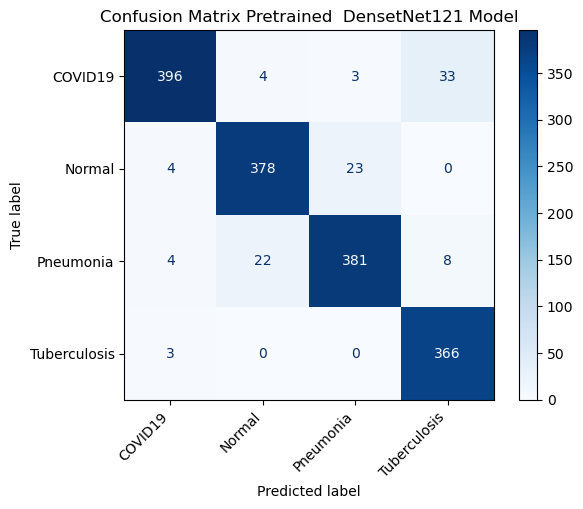

In [43]:
## Confusion metrics 
accuracy = accuracy_score(all_preds, all_labels)
print(f"Accuracy: {accuracy}")
print('\n classification Report')
cls_report = classification_report(all_preds, all_labels)
print(cls_report)

cm = confusion_matrix(all_preds, all_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
display.plot(cmap='Blues')
plt.xticks(rotation = 45, ha= 'right')
plt.title('Confusion Matrix Pretrained  DensetNet121 Model')
plt.show()